In [1]:
%%configure -f
{
    "conf": {
        "spark.pyspark.python": "python3",
        "spark.pyspark.virtualenv.enabled": "true",
        "spark.pyspark.virtualenv.type":"native",
        "spark.pyspark.virtualenv.bin.path":"/usr/bin/virtualenv"
    }
}

ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
5,application_1716567260010_0007,pyspark,idle,Link,Link,


In [2]:
# install Python packages
sc.install_pypi_package("pandas==1.0.5", "https://pypi.org/simple")
sc.install_pypi_package("scipy==1.4.1", "https://pypi.org/simple")
sc.install_pypi_package("matplotlib==3.2.1", "https://pypi.org/simple")
sc.install_pypi_package("python-louvain", "https://pypi.org/simple")

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
8,application_1716567260010_0010,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached https://files.pythonhosted.org/packages/af/f3/683bf2547a3eaeec15b39cef86f61e921b3b187f250fcd2b5c5fb4386369/pandas-1.0.5-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/ec/57/56b9bcc3c9c6a792fcbaf139543cee77261f3651ca9da0c93f5c1221264b/python_dateutil-2.9.0.post0-py2.py3-none-any.whl

  Using cached https://files.pythonhosted.org/packages/dd/82/c1fe128f3526b128cfd185580ba40d01371c5d299fcf7f77968e22dfcc2e/scipy-1.4.1-cp37-cp37m-manylinux1_x86_64.whl

  Using cached https://files.pythonhosted.org/packages/b2/c2/71fcf957710f3ba1f09088b35776a799ba7dd95f7c2b195ec800933b276b/matplotlib-3.2.1-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/9d/ea/6d76df31432a0e6fdf81681a895f009a4bb47b3c39036db3e1b528191d52/pyparsing-3.1.2-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/5c/f9/695d6bedebd747e5eb0fe8fad57b72fdf25411273a39791cde838d5a8f51/cycler-0.11.0-py3-none-any.whl
  Using cach

In [3]:
# import Python packages
from pyspark.sql.functions import udf, col, split
from pyspark.sql.types import StringType
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
import community.community_louvain as community_louvain

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
# Read JSON file from S3
path = 's3://macs30213-thomas/arxiv.json'
data = spark.read.json(path)
data.printSchema()
num_entries = data.count()
print(f"The dataset contains {num_entries} entries.")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- abstract: string (nullable = true)
 |-- authors: string (nullable = true)
 |-- authors_parsed: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: string (containsNull = true)
 |-- categories: string (nullable = true)
 |-- comments: string (nullable = true)
 |-- doi: string (nullable = true)
 |-- id: string (nullable = true)
 |-- journal-ref: string (nullable = true)
 |-- license: string (nullable = true)
 |-- report-no: string (nullable = true)
 |-- submitter: string (nullable = true)
 |-- title: string (nullable = true)
 |-- update_date: string (nullable = true)
 |-- versions: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- created: string (nullable = true)
 |    |    |-- version: string (nullable = true)

The dataset contains 2481654 entries.

In [5]:
arxiv_fields = {'astro-ph': 'Astronomy',
                'astro-ph.CO': 'Astronomy',
                'astro-ph.EP': 'Astronomy',
                'astro-ph.GA': 'Astronomy',
                'astro-ph.HE': 'Astronomy',
                'astro-ph.IM': 'Astronomy',
                'astro-ph.SR': 'Astronomy',
                'cond-mat.dis-nn': 'Physics',
                'cond-mat.mes-hall': 'Physics',
                'cond-mat.mtrl-sci': 'Physics',
                'cond-mat.other': 'Physics',
                'cond-mat.quant-gas': 'Physics',
                'cond-mat.soft': 'Physics',
                'cond-mat.stat-mech': 'Physics',
                'cond-mat.str-el': 'Physics',
                'cond-mat.supr-con': 'Physics',
                'cond-mat': 'Physics',
                'cs.AI': 'Computer Science',
                'cs.AR': 'Computer Science',
                'cs.CC': 'Computer Science',
                'cs.CE': 'Computer Science',
                'cs.CG': 'Computer Science',
                'cs.CL': 'Computer Science',
                'cs.CR': 'Computer Science',
                'cs.CV': 'Computer Science',
                'cs.CY': 'Computer Science',
                'cs.DB': 'Computer Science',
                'cs.DC': 'Computer Science',
                'cs.DL': 'Computer Science',
                'cs.DM': 'Computer Science',
                'cs.DS': 'Computer Science',
                'cs.ET': 'Computer Science',
                'cs.FL': 'Computer Science',
                'cs.GL': 'Computer Science',
                'cs.GR': 'Computer Science',
                'cs.GT': 'Computer Science',
                'cs.HC': 'Computer Science',
                'cs.IR': 'Computer Science',
                'cs.IT': 'Computer Science',
                'cs.LG': 'Computer Science',
                'cs.LO': 'Computer Science',
                'cs.MA': 'Computer Science',
                'cs.MM': 'Computer Science',
                'cs.MS': 'Computer Science',
                'cs.NA': 'Computer Science',
                'cs.NE': 'Computer Science',
                'cs.NI': 'Computer Science',
                'cs.OH': 'Computer Science',
                'cs.OS': 'Computer Science',
                'cs.PF': 'Computer Science',
                'cs.PL': 'Computer Science',
                'cs.RO': 'Computer Science',
                'cs.SC': 'Computer Science',
                'cs.SD': 'Computer Science',
                'cs.SE': 'Computer Science',
                'cs.SI': 'Computer Science',
                'cs.SY': 'Computer Science',
                'econ.EM': 'Math',
                'eess.AS': 'Physics',
                'eess.IV': 'Physics',
                'eess.SP': 'Physics',
                'gr-qc': 'Astronomy',
                'hep-ex': 'Physics',
                'hep-lat': 'Physics',
                'hep-ph': 'Physics',
                'hep-th': 'Physics',
                'math.AC': 'Math',
                'math.AG': 'Math',
                'math.AP': 'Math',
                'math.AT': 'Math',
                'math.CA': 'Math',
                'math.CO': 'Math',
                'math.CT': 'Math',
                'math.CV': 'Math',
                'math.DG': 'Math',
                'math.DS': 'Math',
                'math.FA': 'Math',
                'math.GM': 'Math',
                'math.GN': 'Math',
                'math.GR': 'Math',
                'math.GT': 'Math',
                'math.HO': 'Math',
                'math.IT': 'Math',
                'math.KT': 'Math',
                'math.LO': 'Math',
                'math.MG': 'Math',
                'math.MP': 'Math',
                'math.NA': 'Math',
                'math.NT': 'Math',
                'math.OA': 'Math',
                'math.OC': 'Math',
                'math.PR': 'Math',
                'math.QA': 'Math',
                'math.RA': 'Math',
                'math.RT': 'Math',
                'math.SG': 'Math',
                'math.SP': 'Math',
                'math.ST': 'Math',
                'math-ph': 'Math',
                'nlin.AO': 'Physics',
                'nlin.CD': 'Physics',
                'nlin.CG': 'Physics',
                'nlin.PS': 'Physics',
                'nlin.SI': 'Physics',
                'nucl-ex': 'Physics',
                'nucl-th': 'Physics',
                'physics.acc-ph': 'Physics',
                'physics.ao-ph': 'Physics',
                'physics.app-ph': 'Physics',
                'physics.atm-clus': 'Physics',
                'physics.atom-ph': 'Physics',
                'physics.bio-ph': 'Physics',
                'physics.chem-ph': 'Physics',
                'physics.class-ph': 'Physics',
                'physics.comp-ph': 'Physics',
                'physics.data-an': 'Physics',
                'physics.ed-ph': 'Physics',
                'physics.flu-dyn': 'Physics',
                'physics.gen-ph': 'Physics',
                'physics.geo-ph': 'Physics',
                'physics.hist-ph': 'Physics',
                'physics.ins-det': 'Physics',
                'physics.med-ph': 'Physics',
                'physics.optics': 'Physics',
                'physics.plasm-ph':'Physics',
                'physics.pop-ph': 'Physics',
                'physics.soc-ph': 'Physics',
                'physics.space-ph': 'Physics',
                'q-bio.BM': 'Physics',
                'q-bio.CB': 'Physics',
                'q-bio.GN': 'Physics',
                'q-bio.MN': 'Physics',
                'q-bio.NC': 'Physics',
                'q-bio.OT': 'Physics',
                'q-bio.PE': 'Physics',
                'q-bio.QM': 'Physics',
                'q-bio.SC': 'Physics',
                'q-bio.TO': 'Physics',
                'q-fin.CP': 'Math',
                'q-fin.EC': 'Math',
                'q-fin.GN': 'Math',
                'q-fin.MF': 'Math',
                'q-fin.PM': 'Math',
                'q-fin.PR': 'Math',
                'q-fin.RM': 'Math',
                'q-fin.ST': 'Math',
                'q-fin.TR': 'Math',
                'quant-ph': 'Physics',
                'stat.AP': 'Math',
                'stat.CO': 'Math',
                'stat.ME': 'Math',
                'stat.ML': 'Math',
                'stat.OT': 'Math',
                'stat.TH': 'Math',
                'supr-con': 'Physics',
                'econ.GN': 'Math',
                'mtrl-th': 'Physics',
                'dg-ga': 'Math',
                'comp-gas': 'Physics',
                'cmp-lg': 'Computer Science',
                'solv-int': 'Physics',
                'acc-phys': 'Physics',
                'patt-sol': 'Physics',
                'funct-an': 'Math',
                'econ.TH': 'Math',
                'ao-sci': 'Physics',
                'q-alg': 'Math',
                'eess.SY': 'Physics',
                'chem-ph': 'Physics',
                'alg-geom': 'Math',
                'atom-ph': 'Physics',
                'plasm-ph': 'Physics',
                'chao-dyn': 'Physics',
                'bayes-an': 'Math',
                'adap-org': 'Physics'
                }

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
# Extract categories and publication dates
df = data.select('categories', 'update_date')

# Extract the first category
df = df.withColumn("categories", split(col("categories"), " ").getItem(0))

# Create a broadcast variable
broadcast_dict = spark.sparkContext.broadcast(arxiv_fields)

# Map categories to fields
def map_category(categories):
    if categories:
        return broadcast_dict.value.get(categories, "Unknown")
map_category_udf = udf(map_category, StringType())

# Apply UDF
df = df.withColumn("field", map_category_udf(col("categories")))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
# Extract publication years
df = df.withColumn("year", col("update_date").substr(1, 4))

# Display processed data
df = df.select('field', 'year')
df.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+----+
|    field|year|
+---------+----+
|  Physics|2008|
|     Math|2008|
|  Physics|2008|
|     Math|2007|
|     Math|2013|
|  Physics|2015|
|Astronomy|2008|
|  Physics|2009|
|Astronomy|2010|
|     Math|2007|
|     Math|2008|
|     Math|2007|
|     Math|2008|
|     Math|2009|
|  Physics|2009|
|  Physics|2008|
|Astronomy|2009|
|  Physics|2007|
|     Math|2007|
|  Physics|2015|
+---------+----+
only showing top 20 rows

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

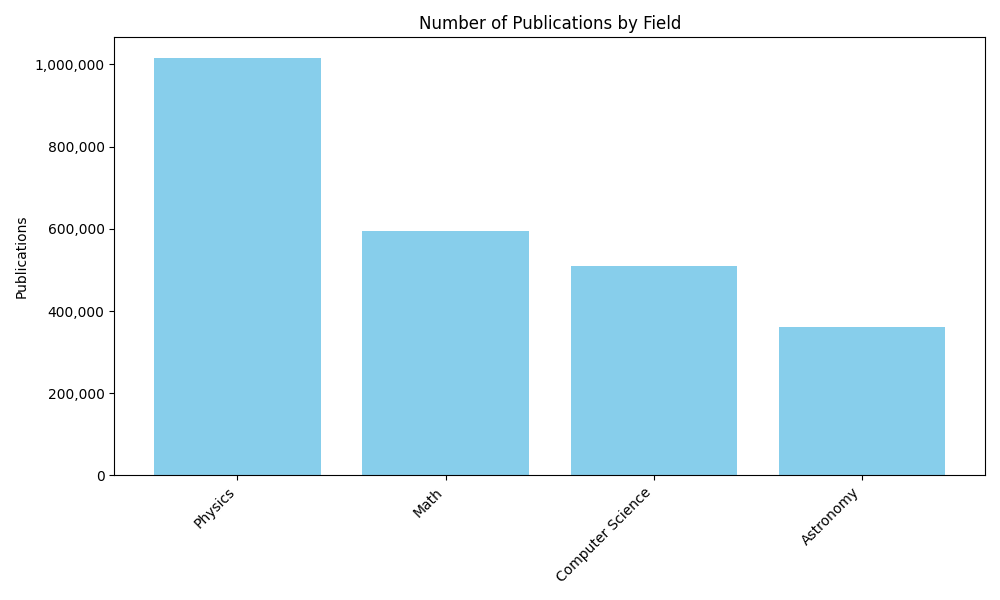

In [8]:
# Count the number of publications in each field
publications_by_field = df.groupBy("field").count().orderBy("count", ascending=False)

# Collect data
publications_by_field = publications_by_field.collect()

# Prepare data
fields = [row['field'] for row in publications_by_field]
counts = [row['count'] for row in publications_by_field]

# Plot
plt.close()
plt.figure(figsize=(10, 6))
plt.bar(fields, counts, color='skyblue')
plt.title('Number of Publications by Field')
plt.ylabel('Publications')
plt.xticks(rotation=45, ha="right")
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.tight_layout()
%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

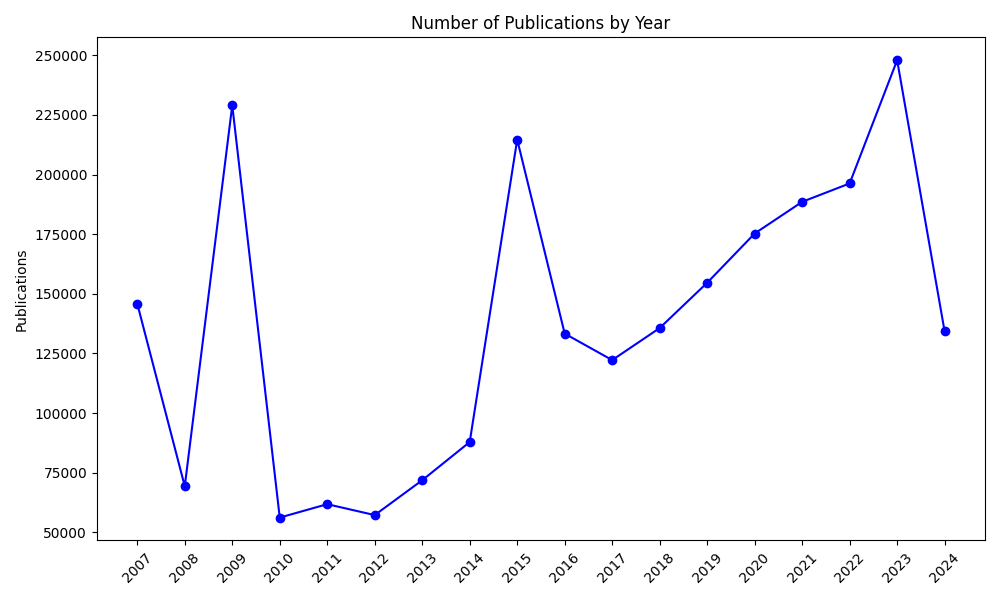

In [9]:
# Count the number of publications in each year
publications_by_year = df.groupBy("year").count().orderBy("year")

# Collect data
publications_by_year = publications_by_year.collect()

# Prepare data
years = [row['year'] for row in publications_by_year]
counts = [row['count'] for row in publications_by_year]

# Plot
plt.close()
plt.figure(figsize=(10, 6))
plt.plot(years, counts, marker='o', linestyle='-', color='b')
plt.title('Number of Publications by Year')
plt.ylabel('Publications')
plt.xticks(years, rotation=45)
plt.tight_layout()
%matplot plt

In [10]:
# Count the number of yearly publications by field
publications_by_year_field = df.groupBy("year", "field").count().orderBy("year", "field")

# Convert to pandas
publications_by_year_field = publications_by_year_field.toPandas()

# Fill NA value with 0
pivot_df = publications_by_year_field.pivot(index='year', columns='field', values='count')
pivot_df = pivot_df.sort_index().fillna(0)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

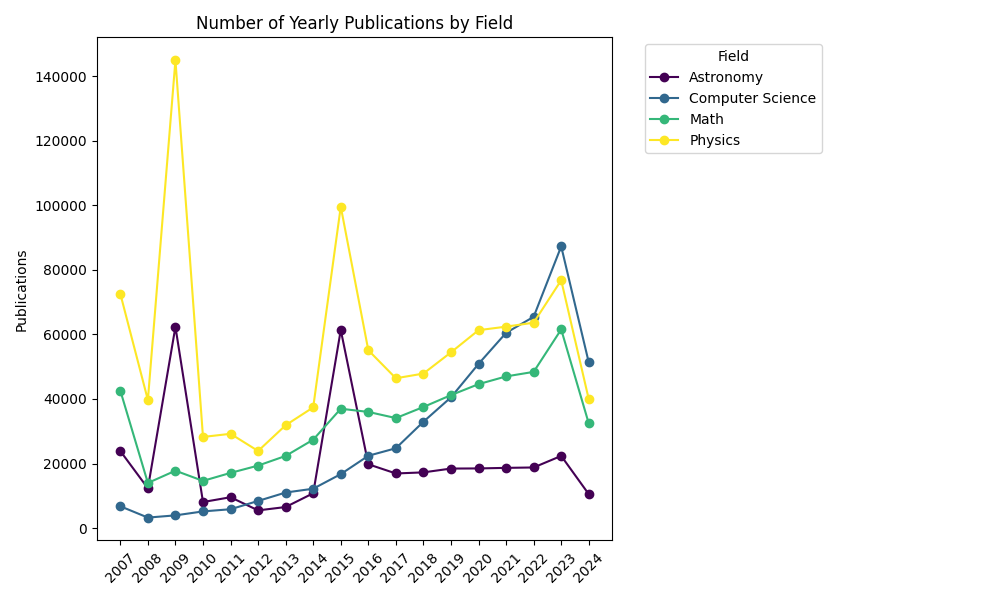

In [11]:
# Plot
plt.close()
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(pivot_df.columns)))

for column, color in zip(pivot_df.columns, colors):
    plt.plot(pivot_df.index, pivot_df[column], marker='o', linestyle='-', label=column, color=color)

plt.title('Number of Yearly Publications by Field')
plt.ylabel('Publications')
plt.legend(title='Field', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout(rect=[0, 0, 0.85, 1])
%matplot plt

In [12]:
# Extract the first category
df = data.withColumn("categories", split(col("categories"), " ").getItem(0))

# Extract 1000 entries of submitters, authors, and categories
df = data.select('submitter', 'authors', 'categories').limit(1000).toPandas()

# Map categories to fields
df['field'] = df['categories'].map(arxiv_fields)

# Split authors
df['authors'] = df['authors'].apply(lambda x: x.split(','))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
# Initialize a graph
plt.close()
G = nx.Graph()

# Define all fields
fields = ['Astronomy', 'Computer Science', 'Math', 'Physics']

# Create color maps for edges
color_map_edges = {field: color for field, color in zip(fields, mcolors.TABLEAU_COLORS)}

# Add nodes and edges
for _, row in df.iterrows():
    submitter = row['submitter']
    authors = row['authors']
    field = row['field']
    G.add_node(submitter, field=field)
    for author in authors:
        G.add_node(author, field=field)
        if field == row['field']:
            G.add_edge(submitter, author, field=field)

# Community detection
partition = community_louvain.best_partition(G)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

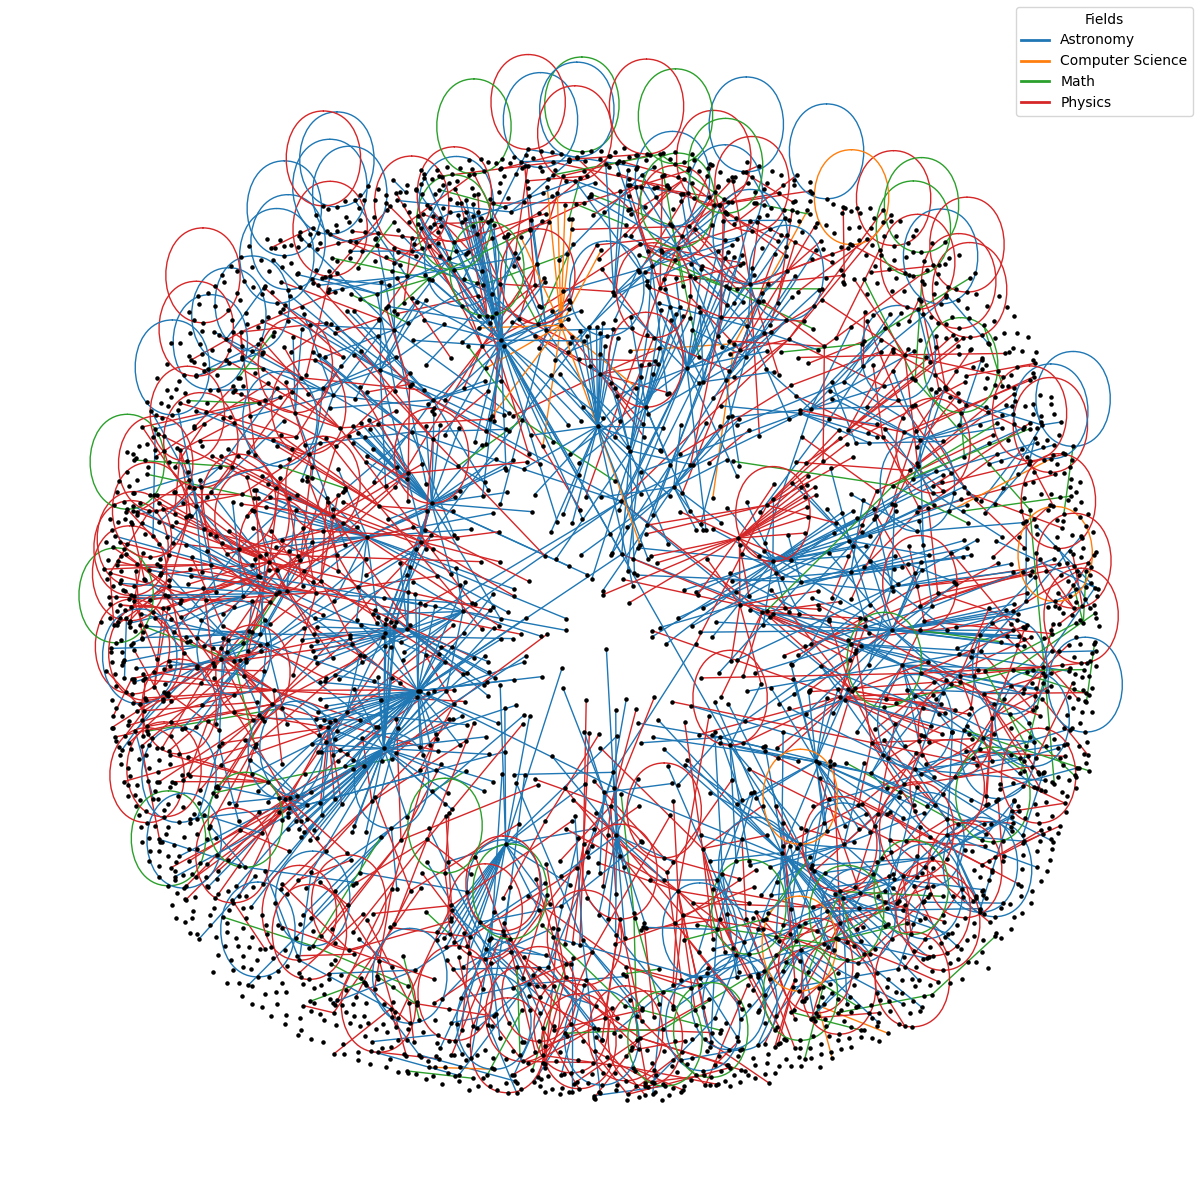

In [14]:
# Create layout
pos = nx.spring_layout(G, k=0.1) 

# Map colors to edges
edge_colors = [color_map_edges[G.edges[edge]['field']] for edge in G.edges]

# Draw networks
plt.figure(figsize=(12, 12))
nx.draw(G, pos, with_labels=False, node_size=5, node_color='black', edge_color=edge_colors)
# Draw lengends
legend_elements = [Line2D([0], [0], color=color, lw=2, label=field) for field, color in color_map_edges.items()]

# Plot
plt.legend(handles=legend_elements, title="Fields", loc="best")
%matplot inline
%matplot plt